Визуальный анализ ряда

Стабилизация дисперсии (при необходимости)

Выбор порядка дифференцирования

Выбор начальных приближений для p, q, P, Qp,q,P,Q

Обучение и сравнение моделей-кандидатов, выбор победителя

Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Qp,q,P,Q.

Прогнозирование с помощью финальной модели.

## 1. Визуальный анализ ряда

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [96]:
data = pd.read_csv('WAG_C_M.csv', sep = ';',index_col=['month'], parse_dates=['month'], dayfirst=True)

In [97]:
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


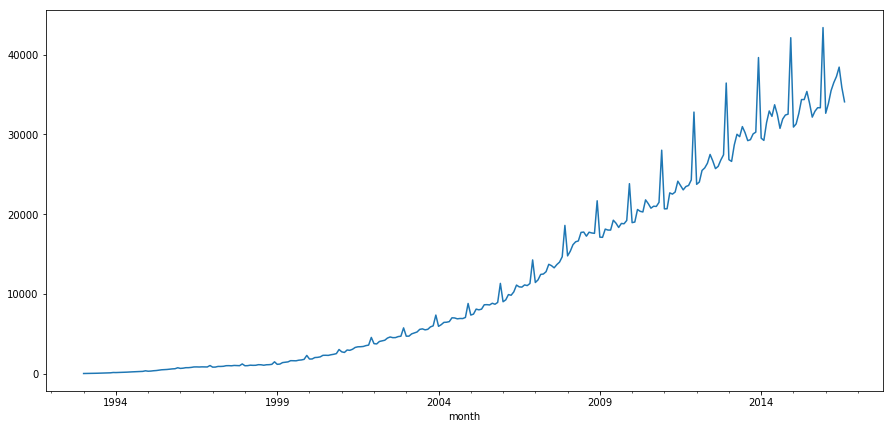

In [98]:
plt.figure(figsize = (15,7))
data.WAG_C_M.plot()

Видно, что ряд не является стационарным: в нем присутствует ярковыраженный тренд и сезонность. А также дисперсия не стабильна.

## 2) Стабилизация дисперсии

In [99]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)

Критерий Дики-Фулера: p=0.696899


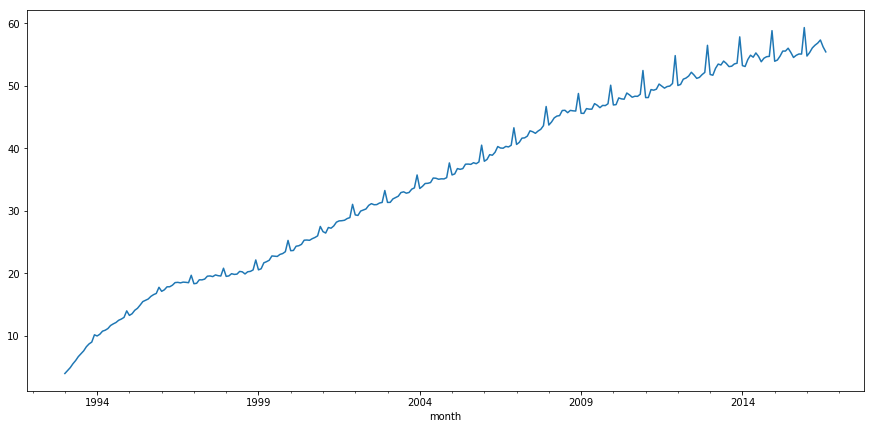

In [100]:
data['WAG_C_M_box'].plot()
print("Критерий Дики-Фулера: p=%f" %sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

## 3) Выбор порядка дифференцирования

In [101]:
data['WAG_C_M_diff_12'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)

Критерий Дики-Фулера: p=0.014697


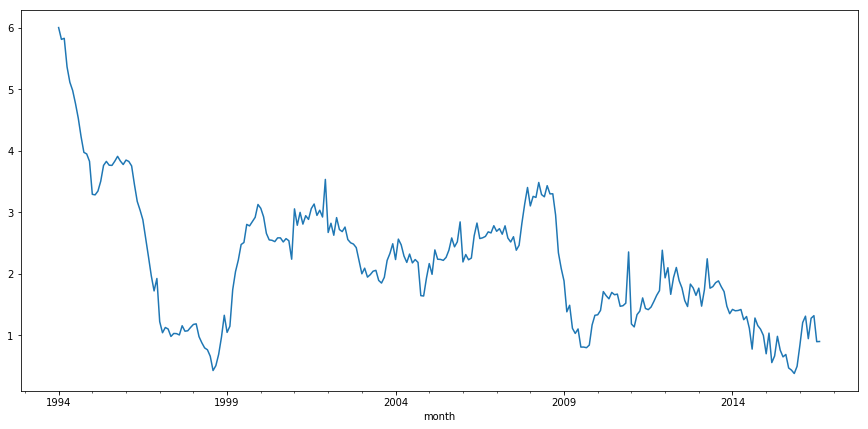

In [102]:
data.WAG_C_M_diff_12.plot()
print("Критерий Дики-Фулера: p=%f" %sm.tsa.stattools.adfuller(data.WAG_C_M_diff_12.dropna())[1])

Для данного ряда нулевая гипотеза а нестационарности отвергается, но по графику видно, что ряд нельзя назвать стационарным. Поэтому продифференцируем еще раз.

In [103]:
data['WAG_C_M_diff_12_1'] = data['WAG_C_M_diff_12'] - data.WAG_C_M_diff_12.shift(1)

Критерий Дики-Фулера: p=0.000000


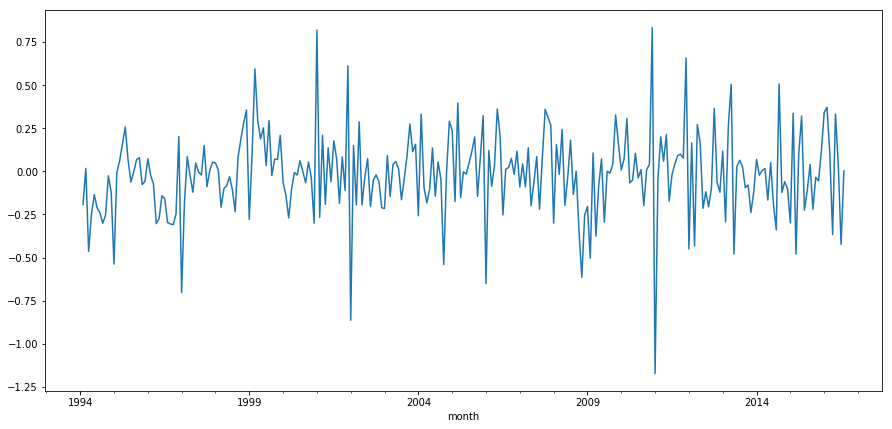

In [104]:
data['WAG_C_M_diff_12_1'].plot()
print("Критерий Дики-Фулера: p=%f" %sm.tsa.stattools.adfuller(data.WAG_C_M_diff_12_1.dropna())[1])

## 4) Выбор начальных приближений для p, q, P, Qp,q,P,Q

In [105]:
d = 1
D = 1


<Figure size 1080x576 with 0 Axes>

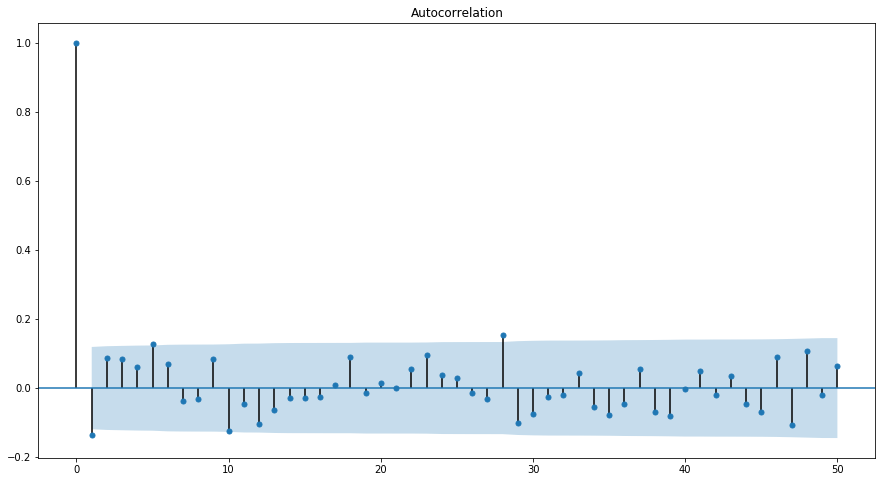

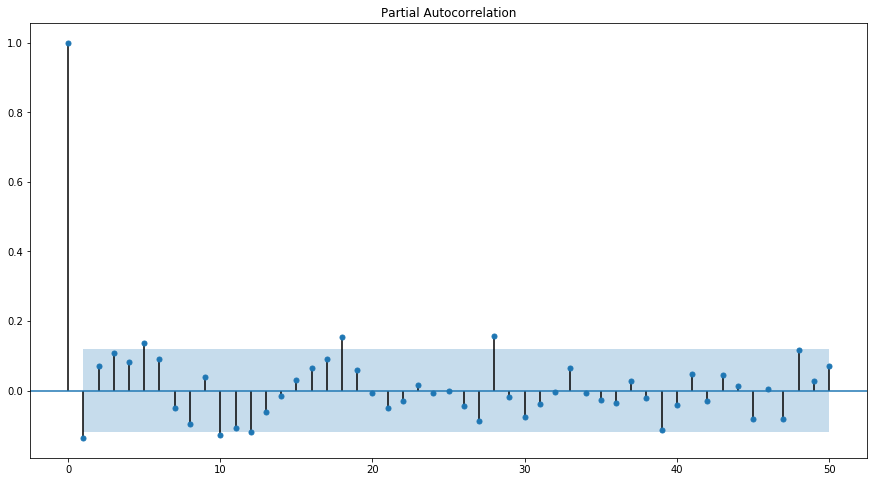

In [106]:
plt.figure(figsize(15,8))
sm.graphics.tsa.plot_acf(data.WAG_C_M_diff_12_1[13:].values.squeeze(), lags = 50)
pylab.show()
sm.graphics.tsa.plot_pacf(data.WAG_C_M_diff_12_1[13:].values.squeeze(), lags = 50)
pylab.show()

Начальные приближения: 
Q=0, q= 5, P = 1, p = 5

## 5) Обучение и сравнение моделей-кандидатов, выбор победителя

In [123]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Q = range(0, 1)
P = range(0, 2)

In [124]:
parameters = product(ps, qs, P, Q)
parameters_list = list(parameters)
len(parameters_list)

72

In [125]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 3, 0, 0))
('wrong parameters:', (2, 3, 1, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 3, 0, 0))
('wrong parameters:', (3, 3, 1, 0))
('wrong parameters:', (3, 4, 0, 0))
('wrong parameters:', (3, 4, 1, 0))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 3, 0, 0))
('wrong parameters:', (4, 3, 1, 0))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4, 1, 0))
('wrong parameters:', (5, 2, 0, 0))
('wrong parameters:', (5, 2, 1, 0))
('wrong parameters:', (5, 3, 0, 0))
('wrong parameters:', (5, 3, 1, 0))
('wrong parameters:', (5, 4, 0, 0))
('wrong parameters:', (5, 4, 1, 0))


LinAlgError: Singular matrix

In [126]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
20  (1, 5, 1, 0) -15.867145
31  (3, 5, 0, 0) -15.223441
32  (3, 5, 1, 0) -15.084378
26  (2, 5, 1, 0) -13.916391
19  (1, 5, 0, 0) -13.661216


## 6) Анализ остатков

In [127]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  15.934
Date:                            Mon, 01 Apr 2019   AIC                            -15.867
Time:                                    18:33:07   BIC                             13.325
Sample:                                01-01-1993   HQIC                            -4.164
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5843      0.153      3.813      0.000       0.284       0.885
ma.L1         -0.8117      0.155   

Критерий Стьюдента: p=0.281232
Критерий Дики-Фуллера: p=0.000000


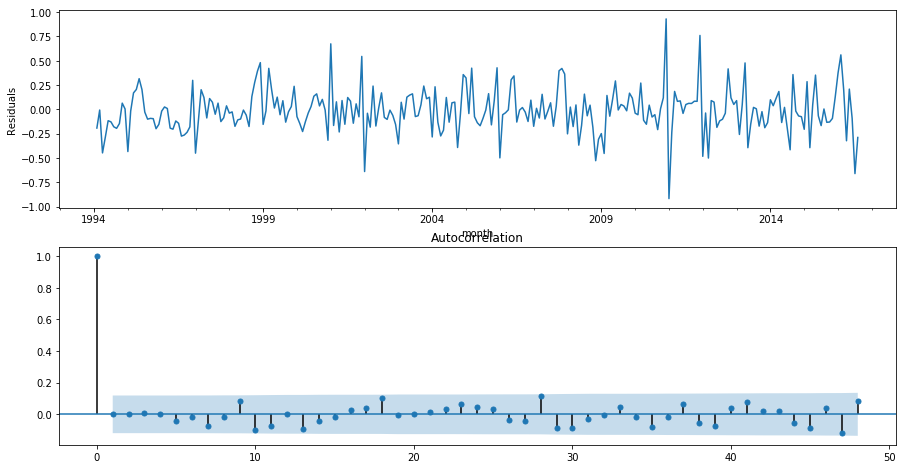

In [113]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

## 7)Прогнозирование с помощью модели

In [132]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

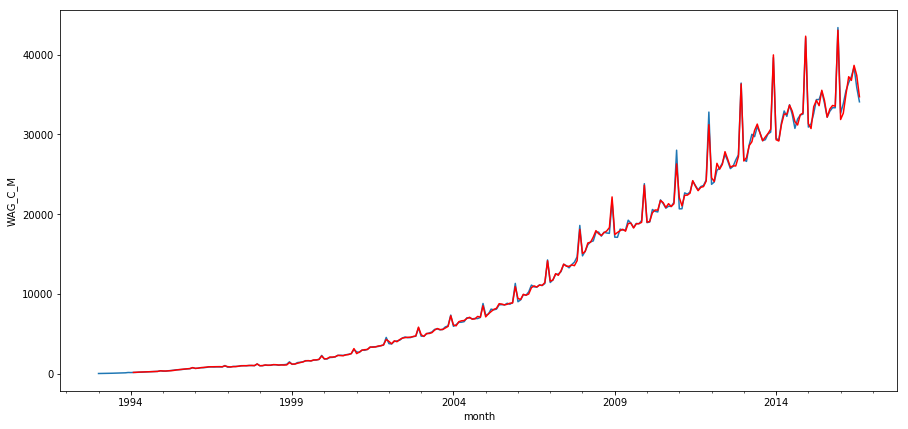

In [133]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

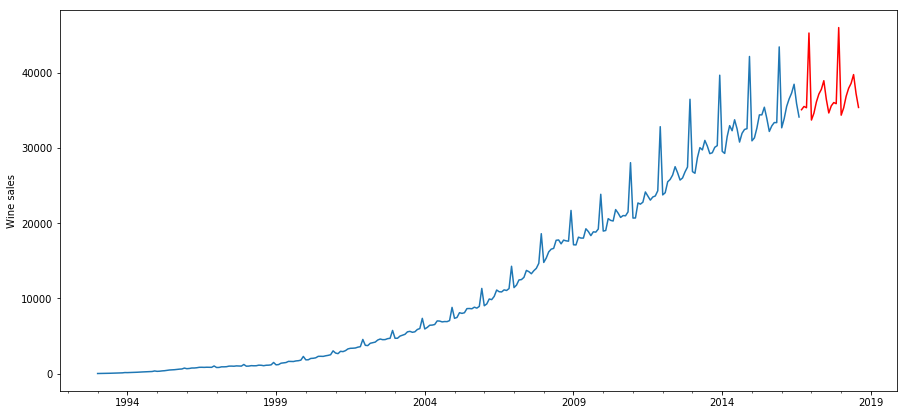

In [134]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=309), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

In [135]:
data.shape

(284, 5)